<a href="https://www.kaggle.com/code/tenzinjampa/calorie-predictor?scriptVersionId=241316310" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e5/sample_submission.csv
/kaggle/input/playground-series-s5e5/train.csv
/kaggle/input/playground-series-s5e5/test.csv


# Calorie Predictor: Training the Model

In [2]:
df = pd.read_csv('/kaggle/input/playground-series-s5e5/train.csv')

In [3]:
df.head()

,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,0,male,36,189.0,82.0,26.0,101.0,41.0,150.0
1,1,female,64,163.0,60.0,8.0,85.0,39.7,34.0
2,2,female,51,161.0,64.0,7.0,84.0,39.8,29.0
3,3,male,20,192.0,90.0,25.0,105.0,40.7,140.0
4,4,female,38,166.0,61.0,25.0,102.0,40.6,146.0


In [4]:
n, m = df.shape 
print(f'The no of data samples in the data set is {n}')
print(f'The no of features in the data set is {m -1}')

The no of data samples in the data set is 750000
The no of features in the data set is 8


In [5]:
list(df.columns)

['id',
 'Sex',
 'Age',
 'Height',
 'Weight',
 'Duration',
 'Heart_Rate',
 'Body_Temp',
 'Calories']

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   id          750000 non-null  int64  
 1   Sex         750000 non-null  object 
 2   Age         750000 non-null  int64  
 3   Height      750000 non-null  float64
 4   Weight      750000 non-null  float64
 5   Duration    750000 non-null  float64
 6   Heart_Rate  750000 non-null  float64
 7   Body_Temp   750000 non-null  float64
 8   Calories    750000 non-null  float64
dtypes: float64(6), int64(2), object(1)
memory usage: 51.5+ MB


## Data preparation

In [7]:
## preparing the column names 

df.columns = df.columns.str.lower().str.replace(' ', '_')
df.head()

,id,sex,age,height,weight,duration,heart_rate,body_temp,calories
0,0,male,36,189.0,82.0,26.0,101.0,41.0,150.0
1,1,female,64,163.0,60.0,8.0,85.0,39.7,34.0
2,2,female,51,161.0,64.0,7.0,84.0,39.8,29.0
3,3,male,20,192.0,90.0,25.0,105.0,40.7,140.0
4,4,female,38,166.0,61.0,25.0,102.0,40.6,146.0


In [8]:
## we don't need the id of the peoples as they are not that useful
## Extract the features we are interested in!

features = [
     'sex',
     'age',
     'height',
     'weight',
     'duration',
     'heart_rate',
     'body_temp',
     'calories' ## This is the target variable
 ]

df = df[features] 
df.head()

,sex,age,height,weight,duration,heart_rate,body_temp,calories
0,male,36,189.0,82.0,26.0,101.0,41.0,150.0
1,female,64,163.0,60.0,8.0,85.0,39.7,34.0
2,female,51,161.0,64.0,7.0,84.0,39.8,29.0
3,male,20,192.0,90.0,25.0,105.0,40.7,140.0
4,female,38,166.0,61.0,25.0,102.0,40.6,146.0


In [9]:
## Treating NAN data

df.isnull().sum() #no missing data

sex           0
age           0
height        0
weight        0
duration      0
heart_rate    0
body_temp     0
calories      0
dtype: int64

## Exploratory Data Analysis

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### What's the distribution of the calorie variable?

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Count'>

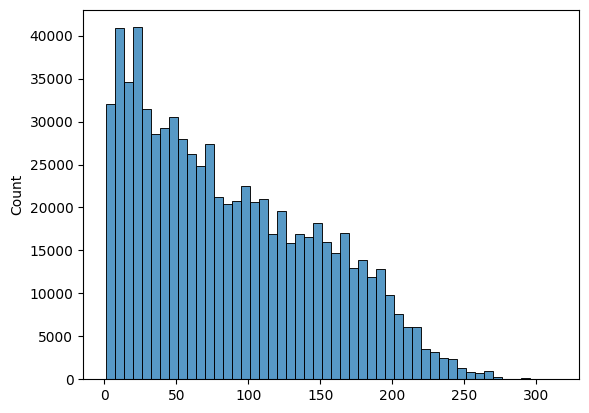

In [11]:
calories = df.calories.values
sns.histplot(calories, bins = 50) 

We see above that the calorie variable is not a random variable that is normally distributed. It looks like it has an exponential decay with a long tail. let's take the log of the data to tame it!

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Count'>

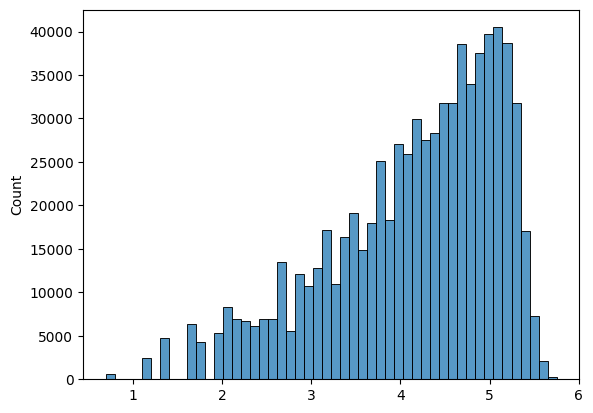

In [12]:
log_calories = np.log1p(calories)
sns.histplot(log_calories, bins = 50)

In [13]:
df.calories = log_calories 
df.calories.head()

0    5.017280
1    3.555348
2    3.401197
3    4.948760
4    4.990433
Name: calories, dtype: float64

### Correlation between Numerical Values

In [14]:
categorical = ['sex']
numerical = list(set(df.columns) - set(categorical))
print(numerical)

['age', 'weight', 'body_temp', 'duration', 'calories', 'heart_rate', 'height']


<Axes: >

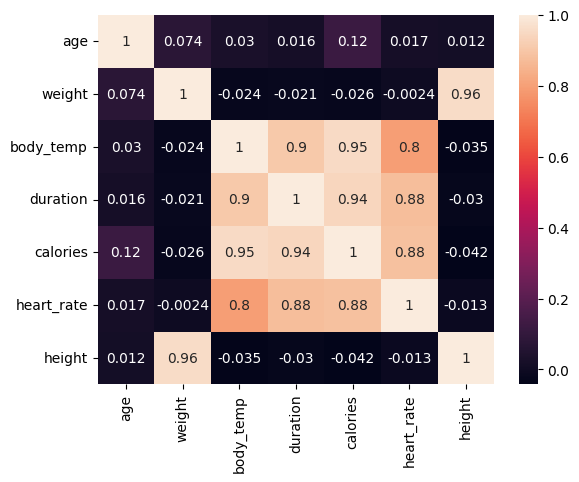

In [15]:
corr_matrix = df[numerical].corr()
sns.heatmap(corr_matrix, annot = True)


What about the distribution of gender in terms of calories?

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

<Axes: xlabel='calories', ylabel='Probability'>

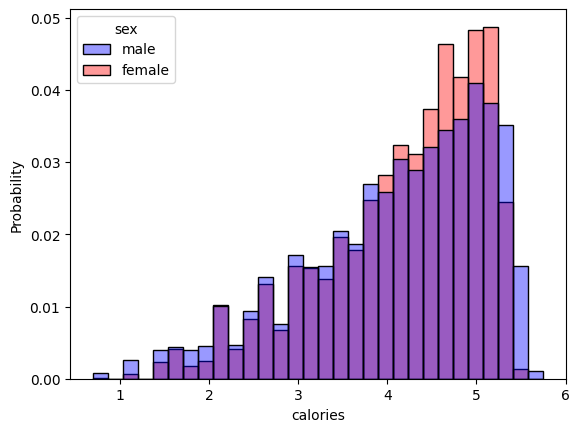

In [16]:
sns.histplot(data=df, x='calories', hue='sex', 
             palette={'male': 'blue', 'female': 'red'}, 
             alpha=0.4, bins=30, stat='probability')

The log_calories distribution per gender overlaps quite a lot with the male having a higher peak of probability for certain calories

In [17]:
df.describe()

,age,height,weight,duration,heart_rate,body_temp,calories
count,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000
mean,41.420404,174.697685,75.145668,15.421015,95.483995,40.036253,4.141144
std,15.175049,12.824496,13.982704,8.354095,9.449845,0.779875,0.963231
min,20.000000,126.000000,36.000000,1.000000,67.000000,37.100000,0.693147
25%,28.000000,164.000000,63.000000,8.000000,88.000000,39.600000,3.555348
50%,40.000000,174.000000,74.000000,15.000000,95.000000,40.300000,4.356709
75%,52.000000,185.000000,87.000000,23.000000,103.000000,40.700000,4.919981
max,79.000000,222.000000,132.000000,30.000000,128.000000,41.500000,5.752573


In [18]:
df['sex'].value_counts()


sex
female    375721
male      374279
Name: count, dtype: int64

### Mutual Information Score

In [19]:
from sklearn.metrics import mutual_info_score

In [20]:
scores = mutual_info_score(df.calories, df.weight)
scores

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)


0.06801325899704724

In [21]:
def mutual_info_y_score(series):
    return mutual_info_score(series, df.calories)

mi = df[numerical].apply(mutual_info_y_score).round(5)
mi = mi.sort_values(ascending = False).to_frame(name = "MI")
mi

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received multiclass values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received multiclass values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received multiclass values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/usr/loc

,MI
calories,5.36087
duration,1.64379
body_temp,1.12536
heart_rate,0.98281
age,0.10861
height,0.06812
weight,0.06801


## Encoding the categorical Sex variable

### Option 1:
Let's encode the sex as {1,0}

In [22]:
df.sex = (df.sex == 'male').astype(int) ## { male: 1, female: 0}
df.head()

,sex,age,height,weight,duration,heart_rate,body_temp,calories
0,1,36,189.0,82.0,26.0,101.0,41.0,5.017280
1,0,64,163.0,60.0,8.0,85.0,39.7,3.555348
2,0,51,161.0,64.0,7.0,84.0,39.8,3.401197
3,1,20,192.0,90.0,25.0,105.0,40.7,4.948760
4,0,38,166.0,61.0,25.0,102.0,40.6,4.990433


## Preparing the Data splits of Train/Val/Test (60/20/20)

In [23]:
from sklearn.model_selection import train_test_split

In [24]:
df_fulltrain, df_test = train_test_split(df, test_size = 0.2, random_state = 42)
df_fulltrain.shape, df_test.shape

((600000, 8), (150000, 8))

In [25]:
df_train, df_val = train_test_split(df_fulltrain, test_size = 0.25)
df_train.shape, df_val.shape

((450000, 8), (150000, 8))

In [26]:
assert len(df) == len(df_train) + len(df_val) + len(df_test)

In [27]:
## let's reset the index of the split data

df_fulltrain = df_fulltrain.reset_index(drop = True)
df_train = df_train.reset_index(drop = True)
df_val = df_val.reset_index(drop = True)
df_test = df_test.reset_index(drop = True)

In [28]:
df_test.head()

,sex,age,height,weight,duration,heart_rate,body_temp,calories
0,0,56,163.0,61.0,29.0,108.0,40.8,5.303305
1,1,44,179.0,87.0,13.0,94.0,40.3,4.174387
2,1,41,186.0,84.0,10.0,89.0,39.9,3.688879
3,0,38,161.0,58.0,19.0,98.0,40.6,4.644391
4,1,57,181.0,77.0,9.0,98.0,40.0,3.970292


In [29]:
## Target variable

y_fulltrain = df_fulltrain.calories.values
y_train = df_train.calories.values
y_val = df_val.calories.values
y_test = df_test.calories.values

## delete the target variables

del df_fulltrain['calories']
del df_train['calories']
del df_val['calories']
del df_test['calories']

In [30]:
df_train.head(7)

,sex,age,height,weight,duration,heart_rate,body_temp
0,1,40,193.0,99.0,24.0,105.0,40.4
1,1,21,171.0,71.0,11.0,88.0,40.0
2,1,29,187.0,85.0,16.0,102.0,40.6
3,0,22,164.0,60.0,19.0,97.0,40.5
4,1,52,197.0,101.0,18.0,103.0,40.5
5,1,32,185.0,88.0,17.0,99.0,40.3
6,1,34,187.0,89.0,26.0,104.0,41.0


In [31]:
y_fulltrain[:7]

array([3.25809654, 4.21950771, 4.46590812, 1.79175947, 4.81218436,
       5.19295685, 5.07517382])

## Extract the Training Data Matrix

In [32]:
X_train = df_train.values
#print(X_train)
ones = np.ones(X_train.shape[0])
#print(ones)
X_train = np.column_stack([ones, X_train])
X_train

array([[  1. ,   1. ,  40. , ...,  24. , 105. ,  40.4],
       [  1. ,   1. ,  21. , ...,  11. ,  88. ,  40. ],
       [  1. ,   1. ,  29. , ...,  16. , 102. ,  40.6],
       ...,
       [  1. ,   1. ,  23. , ...,  27. , 108. ,  40.4],
       [  1. ,   0. ,  39. , ...,   4. ,  74. ,  38.5],
       [  1. ,   0. ,  25. , ...,   9. ,  89. ,  39.7]])

In [33]:
X_train.shape, y_train.shape

((450000, 8), (450000,))

## Training a Linear Model 

In [34]:
from sklearn.linear_model import LinearRegression

In [35]:
model = LinearRegression()

In [36]:
model.fit(X_train, y_train)

LinearRegression()

In [37]:
x_trial = X_train[:2]
y_trial = model.predict(x_trial)
print(y_trial)

[4.83939695 3.65598858]


### Fit Parameters and interpretation

In [38]:
w0 = model.intercept_
print(w0)
w1 = model.coef_
print(w1)

-25.69859205177316
[ 0.         -0.06760667  0.00585256 -0.00174312  0.00257164  0.02710979
  0.02450121  0.6740114 ]


In [39]:
df_train.head()

,sex,age,height,weight,duration,heart_rate,body_temp
0,1,40,193.0,99.0,24.0,105.0,40.4
1,1,21,171.0,71.0,11.0,88.0,40.0
2,1,29,187.0,85.0,16.0,102.0,40.6
3,0,22,164.0,60.0,19.0,97.0,40.5
4,1,52,197.0,101.0,18.0,103.0,40.5


In [40]:
features_weights = {}

for i, c in enumerate(df_train.columns):
    features_weights[c] = w1[i+1]

print(features_weights)



{'sex': -0.06760666507983516, 'age': 0.005852555810554877, 'height': -0.0017431157331440489, 'weight': 0.002571643127905296, 'duration': 0.027109792009679515, 'heart_rate': 0.02450120504401418, 'body_temp': 0.6740114000083353}


## Model Evaluation using Validation and Test Set

In [41]:
from sklearn.metrics import mean_squared_log_error

In [42]:
y_train_log_preds = model.predict(X_train)
y_train_preds= np.expm1(y_train_log_preds)
RMSE_train = np.sqrt(mean_squared_log_error(np.expm1(y_train), model.predict(X_train)))
RMSE_train

2.636144205362733

### Validation Set

In [43]:
X_val = df_val.values
#print(X_train)
ones = np.ones(X_val.shape[0])
#print(ones)
X_val = np.column_stack([ones, X_val])
X_val

array([[  1. ,   0. ,  21. , ...,   7. ,  80. ,  39.5],
       [  1. ,   0. ,  55. , ...,  27. , 109. ,  40.9],
       [  1. ,   0. ,  26. , ...,   6. ,  73. ,  39.1],
       ...,
       [  1. ,   0. ,  44. , ...,  13. ,  91. ,  39.9],
       [  1. ,   1. ,  48. , ...,  27. , 109. ,  40.7],
       [  1. ,   1. ,  29. , ...,  19. ,  97. ,  40.7]])

In [44]:
y_val_log_preds = model.predict(X_val)
y_val_preds= np.expm1(y_val_log_preds)
RMSE_val = np.sqrt(mean_squared_log_error(np.expm1(y_val), y_val_preds))
RMSE_val

0.1797040734485008

### Test Set

In [45]:
X_test = df_test.values
ones = np.ones(X_test.shape[0])
X_test = np.column_stack([ones, X_test])
X_test

array([[  1. ,   0. ,  56. , ...,  29. , 108. ,  40.8],
       [  1. ,   1. ,  44. , ...,  13. ,  94. ,  40.3],
       [  1. ,   1. ,  41. , ...,  10. ,  89. ,  39.9],
       ...,
       [  1. ,   0. ,  37. , ...,   7. ,  96. ,  39.2],
       [  1. ,   0. ,  21. , ...,  10. ,  86. ,  39.7],
       [  1. ,   0. ,  40. , ...,  26. , 109. ,  41.1]])

In [46]:
y_test_log_preds = model.predict(X_test)
y_test_preds= np.expm1(y_test_log_preds)
RMSE_test = np.sqrt(mean_squared_log_error(np.expm1(y_test), y_test_preds))
RMSE_test

0.1792740141733216

## Applying the trained model on the submission data

In [47]:
df_submission = pd.read_csv('/kaggle/input/playground-series-s5e5/test.csv')

In [48]:
df_submission.head()

,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp
0,750000,male,45,177.0,81.0,7.0,87.0,39.8
1,750001,male,26,200.0,97.0,20.0,101.0,40.5
2,750002,female,29,188.0,85.0,16.0,102.0,40.4
3,750003,female,39,172.0,73.0,20.0,107.0,40.6
4,750004,female,30,173.0,67.0,16.0,94.0,40.5


In [49]:
df_submission.columns = df_submission.columns.str.lower().str.replace(' ', '_')
df_submission.columns

Index(['id', 'sex', 'age', 'height', 'weight', 'duration', 'heart_rate',
       'body_temp'],
      dtype='object')

In [50]:
df_submission.sex = (df_submission.sex == 'male').astype(int)
df_submission.head()

,id,sex,age,height,weight,duration,heart_rate,body_temp
0,750000,1,45,177.0,81.0,7.0,87.0,39.8
1,750001,1,26,200.0,97.0,20.0,101.0,40.5
2,750002,0,29,188.0,85.0,16.0,102.0,40.4
3,750003,0,39,172.0,73.0,20.0,107.0,40.6
4,750004,0,30,173.0,67.0,16.0,94.0,40.5


In [51]:
sub_features = list(features_weights)
sub_features

['sex', 'age', 'height', 'weight', 'duration', 'heart_rate', 'body_temp']

In [52]:
## Data Matrix for Submission

X_sub = df_submission[sub_features].values
ones = np.ones(X_sub.shape[0])
X_sub = np.column_stack([ones, X_sub])
X_sub

array([[  1. ,   1. ,  45. , ...,   7. ,  87. ,  39.8],
       [  1. ,   1. ,  26. , ...,  20. , 101. ,  40.5],
       [  1. ,   0. ,  29. , ...,  16. , 102. ,  40.4],
       ...,
       [  1. ,   0. ,  31. , ...,  14. ,  98. ,  40.1],
       [  1. ,   0. ,  62. , ...,  25. , 106. ,  40.7],
       [  1. ,   1. ,  31. , ...,  15. ,  98. ,  39.9]])

In [53]:
y_sub_log = model.predict(X_sub)
y_sub_preds = np.expm1(y_sub_log)
y_sub_preds

array([ 33.60385204,  98.59114161,  91.29187613, ...,  63.71957339,
       190.11223413,  54.48141265])

In [54]:
df_sub = np.column_stack([df_submission.id.values, y_sub_preds])
df_sub

array([[7.50000000e+05, 3.36038520e+01],
       [7.50001000e+05, 9.85911416e+01],
       [7.50002000e+05, 9.12918761e+01],
       ...,
       [9.99997000e+05, 6.37195734e+01],
       [9.99998000e+05, 1.90112234e+02],
       [9.99999000e+05, 5.44814126e+01]])

In [55]:
df_sub = pd.DataFrame(df_sub)
df_sub.head()


,0,1
0,750000.0,33.603852
1,750001.0,98.591142
2,750002.0,91.291876
3,750003.0,139.647855
4,750004.0,79.002456


In [56]:
df_sub.columns = ['id', 'Calories']
df_sub.id = df_sub.id.astype(int)
df_sub.head()

,id,Calories
0,750000,33.603852
1,750001,98.591142
2,750002,91.291876
3,750003,139.647855
4,750004,79.002456


In [57]:
## let's export the predictions
df_sub.to_csv('submission.csv', index=False)